In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist2 = input_data.read_data_sets("/tmp/data/")

X_train = mnist2.train.images
X_test = mnist2.test.images
X_val = mnist2.validation.images

y_train = mnist2.train.labels.astype("int")
y_test = mnist2.test.labels.astype("int")
y_val = mnist2.validation.labels.astype("int")

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(100)
tf.reset_default_graph()
tf.set_random_seed(100)

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'Greys', interpolation="nearest")
    plt.axis("off")
    pass

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


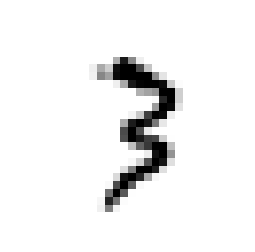

In [2]:
plot_digit(X_train[20000])

In [3]:
n_inputs = 28 * 28
channels = 1

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = 'SAME'

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = 'SAME'

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10

# CNN

In [4]:
with tf.name_scope('inputs'):
    X = tf.placeholder(tf.float32, shape = [None, n_inputs], name = 'X')
    X_reshaped = tf.reshape(X, shape = [-1, 28, 28, channels])
    y = tf.placeholder(tf.int32, shape = [None], name = 'y')
    pass

conv1 = tf.layers.conv2d(X_reshaped, filters = conv1_fmaps, kernel_size = conv1_ksize, 
                         strides = conv1_stride, padding = conv1_pad,
                         activation = tf.nn.relu, name = 'conv1')

conv2 = tf.layers.conv2d(conv1, filters = conv2_fmaps, kernel_size = conv2_ksize, 
                         strides = conv2_stride, padding = conv2_pad,
                         activation = tf.nn.relu, name = 'conv2')

with tf.name_scope('pool3'):
    pool3 = tf.nn.max_pool(conv2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'VALID')
    pool3_flat = tf.reshape(pool3, shape = [-1, pool3_fmaps * 7 * 7])
    pass

with tf.name_scope("full1"):
    full1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")
    pass

with tf.name_scope("output"):
    logits = tf.layers.dense(full1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")
    pass

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    loss_summary = tf.summary.scalar('log_loss', loss)
    pass

with tf.name_scope("train"):    
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    pass

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    accuracy_summary = tf.summary.scalar('accuracy', accuracy)
    pass

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    file_writer = tf.summary.FileWriter('/tmp/model/mnist_dnn-cnn_simple', tf.get_default_graph())
    pass


In [5]:
n_epochs = 10
batch_size = 50

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for iteration in range(X_train.shape[0] // batch_size):
            X_batch, y_batch = mnist2.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            pass
        
        accuracy_val, loss_val, accuracy_summary_str, loss_summary_str = sess.run([accuracy, loss, accuracy_summary, loss_summary], 
                                                                                  feed_dict={X: X_val, y: y_val})
        file_writer.add_summary(accuracy_summary_str, epoch)
        file_writer.add_summary(loss_summary_str, epoch)
        
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print (epoch+1), "Train accuracy: %.4f, Test accuracy: %.4f" % (acc_train, acc_test)
        pass

    save_path = saver.save(sess, "./model9.ckpt")
    pass

1 Train accuracy: 1.0000, Test accuracy: 0.9765
2 Train accuracy: 0.9600, Test accuracy: 0.9848
3 Train accuracy: 1.0000, Test accuracy: 0.9890
4 Train accuracy: 1.0000, Test accuracy: 0.9880
5 Train accuracy: 1.0000, Test accuracy: 0.9882
6 Train accuracy: 1.0000, Test accuracy: 0.9901
7 Train accuracy: 1.0000, Test accuracy: 0.9898
8 Train accuracy: 1.0000, Test accuracy: 0.9900
9 Train accuracy: 1.0000, Test accuracy: 0.9892
10 Train accuracy: 1.0000, Test accuracy: 0.9897


In [6]:
with tf.Session() as sess:
    saver.restore(sess, "./model9.ckpt")
    X_new = X_val[:10]
    y_new = y_val[:10]
    Z = logits.eval(session = sess, feed_dict={X: X_new})
    y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./model9.ckpt


In [7]:
print("Predicted classes:", y_pred)
print("Actual classes:   ", y_new)

('Predicted classes:', array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4]))
('Actual classes:   ', array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4]))
